In [1]:
import pandas as pd
from sklearn.manifold import SpectralEmbedding, TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import scipy
import difflib
import numpy as np

# Content-Based Filtering

There are three main ways to approach recommender systems:
- Collaborative Filtering: This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating).
- Content-Based Filtering: This method uses only information about the description and attributes of the items users have previously consumed to model user's preferences.
- Hybrid methods: Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases.

For extra info please refer to: https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101?scriptVersionId=1477182

This notebook serves only as a POC of a simple content-based filtering recommendation approach. There are various ways to improve upon it and should not be taken as an optimal solution.

In this case, an example dataset possessing various categories will be used, namely a Steam based dataset.

As we can see bellow, the dataset provides information regarding the various games presented on the Steam store page, including their tags positive and negative ratings, as well as their price.

In [2]:
df = pd.read_csv('../lib/data/steam.csv')
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


Since the various categories cannot be processed in a string format let's convert them into a columnar format.

Additionally, since the steam store tags are not always accurate, let's use the steamspy tags instead.

In [3]:
df['steamspy_tags'] = df['steamspy_tags'].str.split(';')
df = pd.concat([df, df['steamspy_tags'].str.join(sep=',').str.get_dummies(sep=',')], axis=1, sort=False)
df

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,0,0,0,0,0,0,1,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1065230,Room of Pandora,2019-04-24,1,SHEN JIAWEI,SHEN JIAWEI,windows,0,Single-player;Steam Achievements,Adventure;Casual;Indie,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,...,0,0,0,0,0,0,0,0,0,0
27072,1065650,Super Star Blast,2019-04-24,1,EntwicklerX,EntwicklerX,windows,0,Single-player;Multi-player;Co-op;Shared/Split ...,Action;Casual;Indie,...,0,0,0,0,0,0,0,0,0,0
27073,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,...,0,0,0,0,0,0,0,0,0,0


We now possess the dataset in a workable format.

We can start by applying dimensional reduction, since we are going to try to find similarity through euclidean distance.

To reduce the dimensionality in the dataset PCA is used (brief explanation at https://www.youtube.com/watch?v=HMOI_lkzW08).

In [4]:
df = df.dropna()

embedding = PCA(n_components=2)
# ['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price']
X_transformed = embedding.fit_transform(df[df.columns.difference(['appid', 'name', 'release_date', 'english', 'developer', 'publisher', 'platforms', 'required_age', 'categories', 'genres', 'steamspy_tags', 'achievements', 'positive_ratings', 'negative_ratings', 'average_playtime', 'median_playtime', 'owners', 'price'])])
df = pd.concat([df, pd.DataFrame(X_transformed, columns=["Comp1", "Comp2"])], axis=1, sort=False)
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports,Comp1,Comp2
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,-0.251195,0.788957
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,-0.251195,0.788957
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,...,0,0,0,0,1,0,0,0,0.501275,0.482476
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,0,0,0,0,0,0,0,-0.251195,0.788957
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,...,0,0,0,0,0,0,0,0,-0.261596,0.771131


Now that we have two components that contain most information about all other encoded ones we can create a plot.

In this case we can see the distribution of games through the classification space.

If the approach was effective similar games should be in relative proximity of each other.

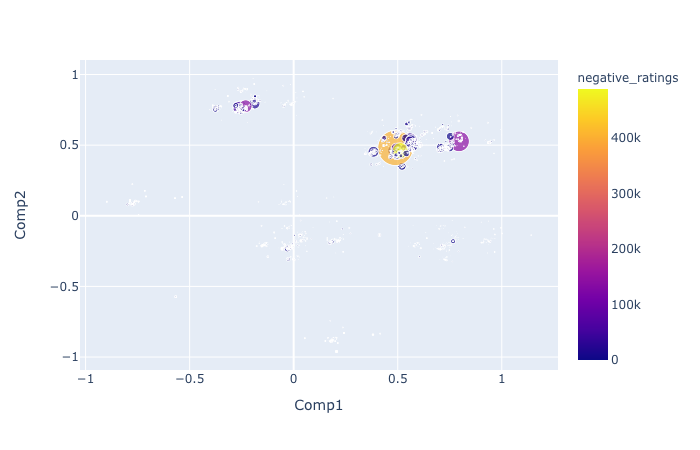

In [5]:
%matplotlib notebook
fig = px.scatter(df, x="Comp1", y="Comp2", size="positive_ratings", color="negative_ratings" , hover_data=['name'])
fig.show("png")

Let's compute the distance between each combination of points as that will ease other actions.

In [6]:
mat = scipy.spatial.distance.cdist(df[['Comp1','Comp2']], df[['Comp1','Comp2']], metric='euclidean')
dist_df = pd.DataFrame(mat, index=df['name'], columns=df['name'])
dist_df

name,Counter-Strike,Team Fortress Classic,Day of Defeat,Deathmatch Classic,Half-Life: Opposing Force,Ricochet,Half-Life,Counter-Strike: Condition Zero,Half-Life: Blue Shift,Half-Life 2,...,12 HOURS,The Mystery of Bikini Island,CaptainMarlene,Old Edge II,Deatherem,Room of Pandora,Cyber Gun,Super Star Blast,New Yankee 7: Deer Hunters,Rune Lord
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,0.000000e+00,1.794350e-14,0.812491,1.296872e-14,0.020638,1.331944e-14,0.017375,1.331944e-14,2.063849e-02,2.063849e-02,...,0.770721,0.676231,0.865347,1.683771e+00,1.040344,1.683771e+00,0.944847,1.397380,1.683771e+00,1.683771e+00
Team Fortress Classic,1.794350e-14,0.000000e+00,0.812491,7.767000e-15,0.020638,7.625260e-15,0.017375,7.625260e-15,2.063849e-02,2.063849e-02,...,0.770721,0.676231,0.865347,1.683771e+00,1.040344,1.683771e+00,0.944847,1.397380,1.683771e+00,1.683771e+00
Day of Defeat,8.124911e-01,8.124911e-01,0.000000,8.124911e-01,0.815656,8.124911e-01,0.818697,8.124911e-01,8.156559e-01,8.156559e-01,...,1.302409,0.152590,0.857887,1.421664e+00,0.886090,1.421664e+00,1.450092,1.501276,1.421664e+00,1.421664e+00
Deathmatch Classic,1.296872e-14,7.767000e-15,0.812491,0.000000e+00,0.020638,3.510833e-16,0.017375,3.510833e-16,2.063849e-02,2.063849e-02,...,0.770721,0.676231,0.865347,1.683771e+00,1.040344,1.683771e+00,0.944847,1.397380,1.683771e+00,1.683771e+00
Half-Life: Opposing Force,2.063849e-02,2.063849e-02,0.815656,2.063849e-02,0.000000,2.063849e-02,0.005194,2.063849e-02,1.110223e-16,1.110223e-16,...,0.750590,0.681314,0.848888,1.668179e+00,1.025246,1.668179e+00,0.924739,1.377678,1.668179e+00,1.668179e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Room of Pandora,1.683771e+00,1.683771e+00,1.421664,1.683771e+00,1.668179,1.683771e+00,1.673360,1.683771e+00,1.668179e+00,1.668179e+00,...,1.370016,1.499441,0.822761,0.000000e+00,0.644908,0.000000e+00,1.356113,0.687322,1.387779e-17,1.387779e-17
Cyber Gun,9.448468e-01,9.448468e-01,1.450092,9.448468e-01,0.924739,9.448468e-01,0.927472,9.448468e-01,9.247394e-01,9.247394e-01,...,0.174189,1.384253,0.762437,1.356113e+00,0.927841,1.356113e+00,0.000000,0.748649,1.356113e+00,1.356113e+00
Super Star Blast,1.397380e+00,1.397380e+00,1.501276,1.397380e+00,1.377678,1.397380e+00,1.382277,1.397380e+00,1.377678e+00,1.377678e+00,...,0.822761,1.511683,0.649422,6.873218e-01,0.639065,6.873218e-01,0.748649,0.000000,6.873218e-01,6.873218e-01


This cell is here mostly for testing purposes, it helps to identify what is the correct name to be used in following cells.

In [7]:
import difflib

difflib.get_close_matches('CounterStrike: Global', list(dist_df), n = 6,cutoff = 0.3)

['Counter-Strike: Global Offensive',
 'Counter-Strike: Source',
 'Counter-Strike',
 'Counter-Strike Nexon: Zombies',
 'Counter-Strike: Condition Zero',
 'Sudden Strike Gold']

Let's test the approach.
What games are closer to CounterStrike?

As we can see mostly other shooters are recomended.

We now have a working recommender based on content. Since a user as set of games he plays various approaches can be taken from here.

The simplest would be to just reccomented similar games to other games the user plays.

Another approach would be to recommend games based on similiraty of pairs or triplets, however, this woul incur the risk of the chosen pairs/triples being to distant from each other, which would mean we could end up with a completely different genre.

In [8]:
def rec_an(name):
    return dist_df.iloc[list(dist_df).index(name)].sort_values(ascending=True)[0:15]
    
 
rec_an("Counter-Strike: Global Offensive")

name
Counter-Strike: Global Offensive      0.000000
生死线 Dead Line                         0.001827
Call of Duty®: Black Ops III          0.002688
Tom Clancy's Rainbow Six® Siege       0.006544
Rising Storm 2: Vietnam               0.007558
Verdun                                0.007582
Tannenberg                            0.007582
Quake Live™                           0.007694
Robot Roller-Derby Disco Dodgeball    0.007904
Post Scriptum                         0.012312
Call of Duty®: WWII                   0.012312
Day of Infamy                         0.012312
Day of Defeat: Source                 0.012312
Day of Defeat                         0.012312
sweet pool                            0.012365
Name: Counter-Strike: Global Offensive, dtype: float64